In [2]:
import yfinance as yf
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import math
import matplotlib.pyplot as plt
import warnings
from ipywidgets import IntProgress, FloatProgress
from IPython.display import display

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 150)


In [3]:
# Parameters
LST_B3_STOCKS = ["ABEV3","ALPA4","ALSO3","ARZZ3","ASAI3","AURE3","AZUL4","B3SA3","BBAS3","BBDC3","BBDC4","BBSE3","BEEF3","BPAC11","BRAP4","BRFS3","BRKM5","CASH3","CBAV3","CCRO3","CIEL3","CMIG4","CMIN3","COGN3","CPFE3","CPLE6","CRFB3","CSAN3","CSMG3","CSNA3","CVCB3","CYRE3","DIRR3","DXCO3","ECOR3","EGIE3","ELET3","ELET6","EMBR3","ENEV3","ENGI11","EQTL3","EZTC3","FLRY3","GGBR4","GMAT3","GOAU4","GOLL4","HAPV3","HYPE3","IGTI11","IRBR3","ITSA4","ITUB4","JBSS3","KLBN11","LREN3","LWSA3","MDIA3","MGLU3","MOVI3","MRFG3","MRVE3","MULT3","NTCO3","PCAR3","PETR3","PETR4","PETZ3","PRIO3","PSSA3","QUAL3","RADL3","RAIL3","RAIZ4","RDOR3","RECV3","RENT3","RRRP3","SANB11","SBSP3","SIMH3","SLCE3","SMTO3","SOMA3","STBP3","SUZB3","TAEE11","TIMS3","TOTS3","TRPL4","UGPA3","USIM5","VALE3","VAMO3","VBBR3","VIVA3","VIVT3","WEGE3","YDUQ3"]
PATH_LS_DATA = 'ls_data/'

In [4]:
def extractYahooData(lst_stock_tickers, start_date, end_date):
    lst_assets=[]
    for ticker in lst_stock_tickers:
        if start_date == end_date:
            df_stock = yf.download(ticker+'.SA', start = start_date)
        else:
            df_stock = yf.download(ticker+'.SA', start = start_date, end = end_date)
        print(ticker)
        if len(df_stock) != 0:
            df_stock = df_stock[["Adj Close"]]
            df_stock.loc[:, "ticker"] = ticker
            lst_assets.append(df_stock)

    return pd.concat(lst_assets)

def transformYahooData(df):
    # Reseting index to pivoting
    df.reset_index(inplace = True)
    
    # Pivoting Data
    df = df.pivot(index = "Date", columns = "ticker", values = "Adj Close")
    
    # Renaming index
    df.index.names = ['date']

    # Fill NA
    df = df.fillna(method='ffill')

    return df

def loadYahooData(df, path_ls_data):
    df.to_csv(path_ls_data+'yahoo_stock_data.csv')
    return None

def etlyahoo(lst_stock_tickers, path_ls_data, start_date = "2018-01-01", end_date = None):
    df = extractYahooData(lst_stock_tickers, start_date, end_date)
    df = transformYahooData(df)
    loadYahooData(df, path_ls_data)
    
    return None

def get_data(path_ls_data, max_date = None):
    if max_date == None:
        return pd.read_csv(path_ls_data+'yahoo_stock_data.csv', index_col = 'date').reset_index()
    else:
        return pd.read_csv(path_ls_data+'yahoo_stock_data.csv', index_col = 'date').loc[:max_date].reset_index()
        
def getPairs(df):
    assets = list(df.columns)
    assets.remove('date')
    
    lst_pairs = []
    for first in assets:
        for second in assets:
            if first != second:
                lst_pairs.append(first+'/'+second)
                
    return lst_pairs

def getPairsResiduals(lst_pairs, df_stocks, col_name_date = 'date', periods = 252):
    df_residuals = pd.DataFrame()
    df_residuals[col_name_date] = df_stocks[col_name_date].sort_values(ascending = False)[:periods]
    
    pairs_column = []
    p_values = []
    adf_column = []
    beta_column = []
    desv_column = []
    halflife_column = []
    
    progress_bar = IntProgress(min=0, max=len(lst_pairs))
    display(progress_bar)
    for i, pair in enumerate(lst_pairs):
        progress_bar.value = i+1
        
        asset1 = pair.split('/')[0]
        asset2 = pair.split('/')[1]
        
        df_res = df_stocks[[col_name_date, asset1, asset2]].sort_values(by=col_name_date, ascending = False)[:periods]
        
        X = df_res.iloc[:, 1].values.reshape(-1, 1)
        Y = df_res.iloc[:, 2].values.reshape(-1, 1)

        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        
        Y_pred = linear_regressor.predict(X)
        df_res['residual'] = Y_pred - Y
        
        df_residuals[pair] = df_res['residual']
        
        mean = df_res['residual'].mean()
        std = df_res['residual'].std()
        
        adf = adfuller(df_res['residual'])
        adf_column.append(adf[0])
        p_values.append((1-adf[1])*100)
        pairs_column.append(pair) 
        beta_column.append(linear_regressor.coef_[0])
        desv_column.append(abs((df_res['residual'].iloc[0] - mean)/std))
        halflife_column.append(math.log(2)/linear_regressor.coef_[0])
    
    dict_stats = {'pair':pairs_column,
                  'adf':adf_column,
                  'beta':beta_column,
                  'desv':desv_column,
                  'halflife':halflife_column,
                  'p_value':p_values
                 }
    
    df_stats = pd.DataFrame(dict_stats)
    
    return df_residuals, df_stats

def double_cointegration(df, check = False):
    if check == True:
        lst_pairs = list(df.pair)
        double_cointegration_pairs = []
        for pair in lst_pairs:
            inverted_pair = pair.split('/')[1]+'/'+pair.split('/')[0]
            if inverted_pair in lst_pairs:
                double_cointegration_pairs.append(pair)
        return df[df["pair"].isin(double_cointegration_pairs)]
    else:
        return df

## ELT Process

In [5]:
etlyahoo(LST_B3_STOCKS, PATH_LS_DATA)

[*********************100%%**********************]  1 of 1 completed


ABEV3


[*********************100%%**********************]  1 of 1 completed


ALPA4


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ALSO3.SA']: Exception('%ticker%: No data found, symbol may be delisted')


ALSO3


[*********************100%%**********************]  1 of 1 completed


ARZZ3


[*********************100%%**********************]  1 of 1 completed


ASAI3


[*********************100%%**********************]  1 of 1 completed


AURE3


[*********************100%%**********************]  1 of 1 completed


AZUL4


[*********************100%%**********************]  1 of 1 completed


B3SA3


[*********************100%%**********************]  1 of 1 completed


BBAS3


[*********************100%%**********************]  1 of 1 completed


BBDC3


[*********************100%%**********************]  1 of 1 completed


BBDC4


[*********************100%%**********************]  1 of 1 completed


BBSE3


[*********************100%%**********************]  1 of 1 completed


BEEF3


[*********************100%%**********************]  1 of 1 completed


BPAC11


[*********************100%%**********************]  1 of 1 completed


BRAP4


[*********************100%%**********************]  1 of 1 completed


BRFS3


[*********************100%%**********************]  1 of 1 completed


BRKM5


[*********************100%%**********************]  1 of 1 completed


CASH3


[*********************100%%**********************]  1 of 1 completed


CBAV3


[*********************100%%**********************]  1 of 1 completed


CCRO3


[*********************100%%**********************]  1 of 1 completed


CIEL3


[*********************100%%**********************]  1 of 1 completed


CMIG4


[*********************100%%**********************]  1 of 1 completed


CMIN3


[*********************100%%**********************]  1 of 1 completed


COGN3


[*********************100%%**********************]  1 of 1 completed


CPFE3


[*********************100%%**********************]  1 of 1 completed


CPLE6


[*********************100%%**********************]  1 of 1 completed


CRFB3


[*********************100%%**********************]  1 of 1 completed


CSAN3


[*********************100%%**********************]  1 of 1 completed


CSMG3


[*********************100%%**********************]  1 of 1 completed


CSNA3


[*********************100%%**********************]  1 of 1 completed


CVCB3


[*********************100%%**********************]  1 of 1 completed


CYRE3


[*********************100%%**********************]  1 of 1 completed


DIRR3


[*********************100%%**********************]  1 of 1 completed


DXCO3


[*********************100%%**********************]  1 of 1 completed


ECOR3


[*********************100%%**********************]  1 of 1 completed


EGIE3


[*********************100%%**********************]  1 of 1 completed


ELET3


[*********************100%%**********************]  1 of 1 completed


ELET6


[*********************100%%**********************]  1 of 1 completed


EMBR3


[*********************100%%**********************]  1 of 1 completed


ENEV3


[*********************100%%**********************]  1 of 1 completed


ENGI11


[*********************100%%**********************]  1 of 1 completed


EQTL3


[*********************100%%**********************]  1 of 1 completed


EZTC3


[*********************100%%**********************]  1 of 1 completed


FLRY3


[*********************100%%**********************]  1 of 1 completed


GGBR4


[*********************100%%**********************]  1 of 1 completed


GMAT3


[*********************100%%**********************]  1 of 1 completed


GOAU4


[*********************100%%**********************]  1 of 1 completed


GOLL4


[*********************100%%**********************]  1 of 1 completed


HAPV3


[*********************100%%**********************]  1 of 1 completed


HYPE3


[*********************100%%**********************]  1 of 1 completed


IGTI11


[*********************100%%**********************]  1 of 1 completed


IRBR3


[*********************100%%**********************]  1 of 1 completed


ITSA4


[*********************100%%**********************]  1 of 1 completed


ITUB4


[*********************100%%**********************]  1 of 1 completed


JBSS3


[*********************100%%**********************]  1 of 1 completed


KLBN11


[*********************100%%**********************]  1 of 1 completed


LREN3


[*********************100%%**********************]  1 of 1 completed


LWSA3


[*********************100%%**********************]  1 of 1 completed


MDIA3


[*********************100%%**********************]  1 of 1 completed


MGLU3


[*********************100%%**********************]  1 of 1 completed


MOVI3


[*********************100%%**********************]  1 of 1 completed


MRFG3


[*********************100%%**********************]  1 of 1 completed


MRVE3


[*********************100%%**********************]  1 of 1 completed


MULT3


[*********************100%%**********************]  1 of 1 completed


NTCO3


[*********************100%%**********************]  1 of 1 completed


PCAR3


[*********************100%%**********************]  1 of 1 completed


PETR3


[*********************100%%**********************]  1 of 1 completed


PETR4


[*********************100%%**********************]  1 of 1 completed


PETZ3


[*********************100%%**********************]  1 of 1 completed


PRIO3


[*********************100%%**********************]  1 of 1 completed


PSSA3


[*********************100%%**********************]  1 of 1 completed


QUAL3


[*********************100%%**********************]  1 of 1 completed


RADL3


[*********************100%%**********************]  1 of 1 completed


RAIL3


[*********************100%%**********************]  1 of 1 completed


RAIZ4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


RDOR3
RECV3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


RENT3
RRRP3


[*********************100%%**********************]  1 of 1 completed


SANB11


[*********************100%%**********************]  1 of 1 completed


SBSP3


[*********************100%%**********************]  1 of 1 completed


SIMH3


[*********************100%%**********************]  1 of 1 completed


SLCE3


[*********************100%%**********************]  1 of 1 completed


SMTO3


[*********************100%%**********************]  1 of 1 completed


SOMA3


[*********************100%%**********************]  1 of 1 completed


STBP3


[*********************100%%**********************]  1 of 1 completed


SUZB3


[*********************100%%**********************]  1 of 1 completed


TAEE11


[*********************100%%**********************]  1 of 1 completed


TIMS3


[*********************100%%**********************]  1 of 1 completed


TOTS3


[*********************100%%**********************]  1 of 1 completed


TRPL4


[*********************100%%**********************]  1 of 1 completed


UGPA3


[*********************100%%**********************]  1 of 1 completed


USIM5


[*********************100%%**********************]  1 of 1 completed


VALE3


[*********************100%%**********************]  1 of 1 completed


VAMO3


[*********************100%%**********************]  1 of 1 completed


VBBR3


[*********************100%%**********************]  1 of 1 completed


VIVA3


[*********************100%%**********************]  1 of 1 completed


VIVT3


[*********************100%%**********************]  1 of 1 completed


WEGE3


[*********************100%%**********************]  1 of 1 completed

YDUQ3


## L&S Screaning

Gerênciamento de risco
- 160 períodos: 1/3 do Capital para cada trade.
- 200 períodos: 1/2 do Capital para cada trade.
- 252 períodos: 100% do Capital para cada trade.


Teste ADF
- 1% -4,32%
- 5% -3,78%
- 10% -3,50%

Interpretação do Beta
- Para cada 1 real do ativo 1, operar beta*reais do ativo 2

In [173]:
# Get stock data
df_stocks = get_data(PATH_LS_DATA, max_date = None)

# Get pairs
list_pairs = getPairs(df_stocks)

# Calculate Residuals between pairs
prds = [252]
lst_df_pairs_res = []
lst_df_pairs_stats = []
for periodo in prds:
    print(f"Calculando estatísticas para período de {periodo} dias...")
    df_pairs_res, df_pairs_stats = getPairsResiduals(list_pairs, df_stocks, col_name_date = 'date', periods = periodo)
    lst_df_pairs_res.append(df_pairs_res)
    lst_df_pairs_stats.append(df_pairs_stats)

Calculando estatísticas para período de 252 dias...


IntProgress(value=0, max=9702)

In [174]:
prd_index = 0
df_pairs_res = lst_df_pairs_res[prd_index]
df_pairs_stats = lst_df_pairs_stats[prd_index]

df_screaning = df_pairs_stats[
    (df_pairs_stats['adf'] <= -4.32) & 
    (df_pairs_stats['desv'] >= 1.50) & 
    (df_pairs_stats['desv'] < 2.5) & 
    (df_pairs_stats['beta'] >= 0.5) & 
    (df_pairs_stats['beta'] < 2) & 
    (df_pairs_stats['halflife'] <= 999)].sort_values(by='desv', ascending=False)

df_screaning = double_cointegration(df_screaning, check = True)

df_screaning.reset_index(drop=True)

,pair,adf,beta,desv,halflife,p_value


IGTI11/CSMG3
Beta:  1.2477645696631234
Desv:  2.4823202023694875
Halflife:  0.5555111897007013


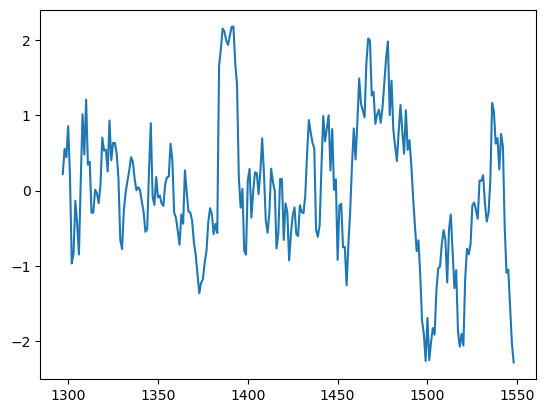

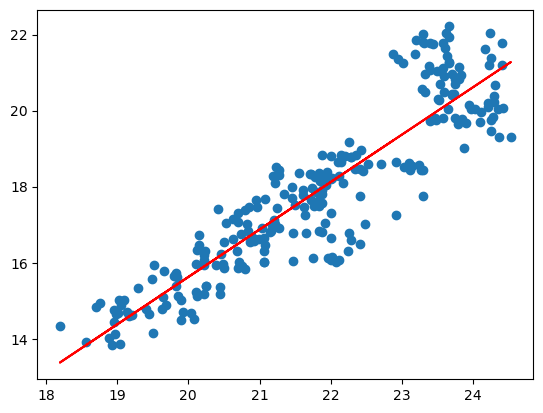

TRPL4/CSMG3
Beta:  1.0474675733506518
Desv:  2.3012878930189578
Halflife:  0.6617361703548472


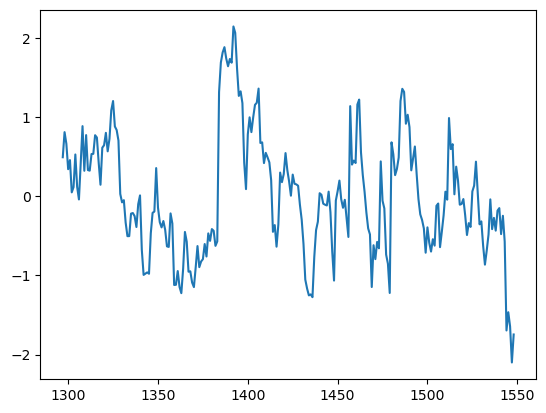

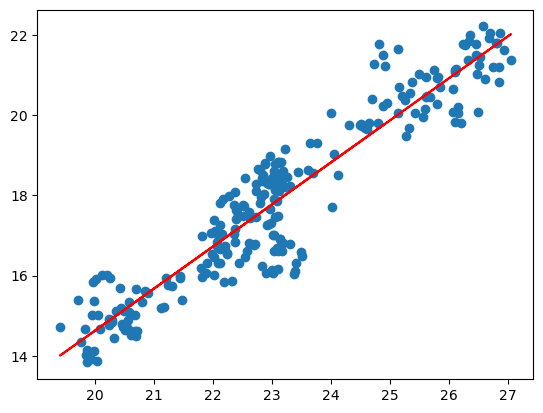

RADL3/EGIE3
Beta:  1.1183647922653481
Desv:  2.142638298894742
Halflife:  0.6197863034975498


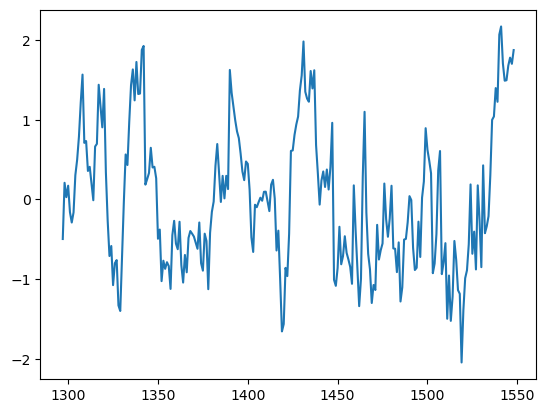

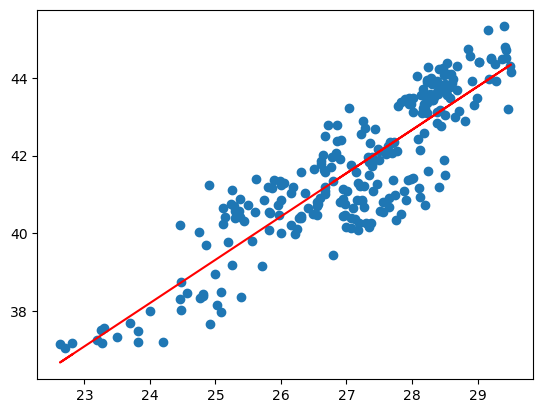

CSMG3/IGTI11
Beta:  0.6586024490825569
Desv:  1.970944473855375
Halflife:  1.0524515685076934


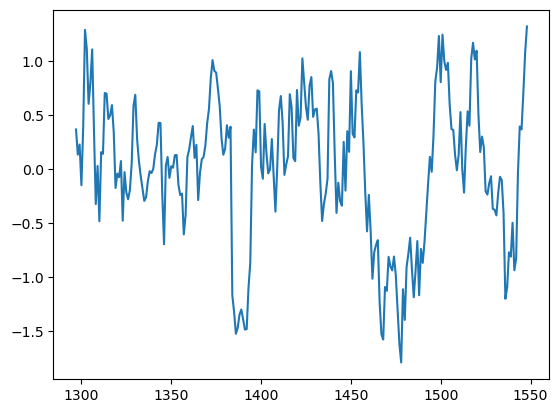

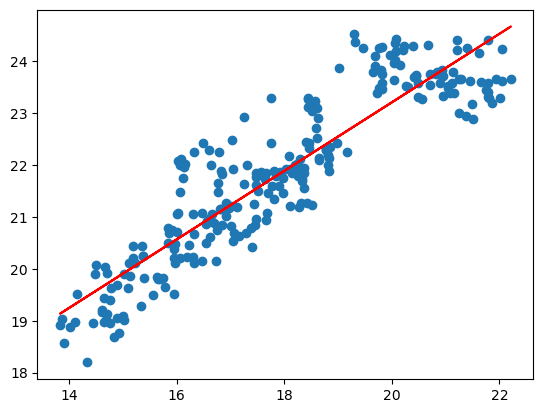

CSMG3/TRPL4
Beta:  0.8389509302237486
Desv:  1.8428903798002096
Halflife:  0.8262070588265307


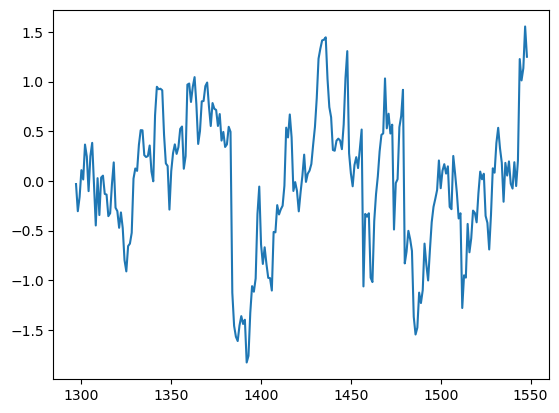

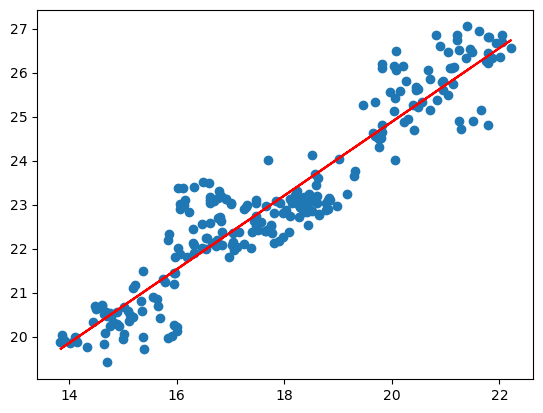

EGIE3/RADL3
Beta:  0.700272216566731
Desv:  1.8108393617121434
Halflife:  0.9898253338655671


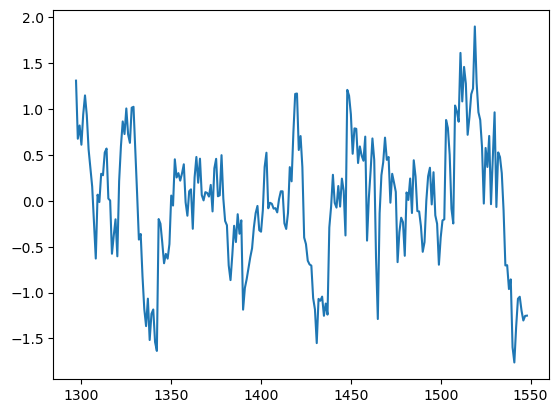

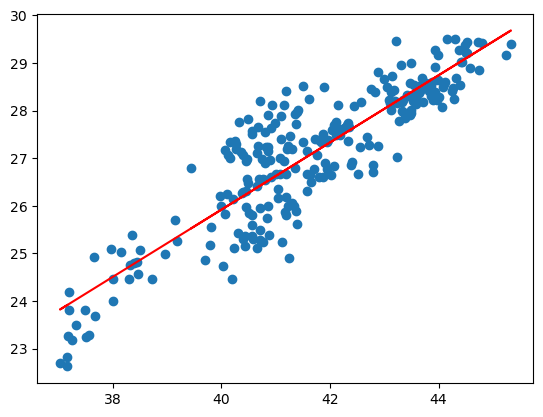

In [168]:
for n_pair in range(len(df_screaning)):

    print(df_screaning.iloc[n_pair,0])
    print("Beta: ", df_screaning.iloc[n_pair,2][0])
    print("Desv: ", df_screaning.iloc[n_pair,3])
    print("Halflife: ", df_screaning.iloc[n_pair,4][0])

    # Residual
    pair1 = df_screaning.iloc[n_pair,0].split('/')[0]
    pair2 = df_screaning.iloc[n_pair,0].split('/')[1]
    plt.plot(df_pairs_res[pair1+'/'+pair2])
    plt.show()

    # Regression
    df_aux = df_stocks[[pair1, pair2]]
    df_aux = df_aux.iloc[-253:, :]
    X = df_aux.iloc[:, 0].values.reshape(-1, 1)
    Y = df_aux.iloc[:, 1].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    
    Y_pred = linear_regressor.predict(X)

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.show()